In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
from lib.utils import  quantile_cutter

I chose to do this project as an introduction to exploring basic data cleaning and machine learning concepts. I retreived a dataset from https://data.calgary.ca/ containing information on property assessment valuations across Calgary properties. The goal of this project was to find a set of features that can be used to predict the assessement value of a property in Calgary. 

First let's open our file and remove any unnamed columns that don't contain any import information

In [4]:
df_init = pd.read_csv(
    "Data/Current_Year_Property_Assessments__Parcel_ (1).csv",engine='python')

In [4]:
df = df_init.copy()
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]

We first need to clean our data so that it can be processed for our model. Let's start by checking for any NaN values.


In [5]:
df.isna().sum()

ROLL_YEAR                            0
ROLL_NUMBER                          0
ADDRESS                              0
ASSESSED_VALUE                     223
ASSESSMENT_CLASS                     0
ASSESSMENT_CLASS_DESCRIPTION         0
RE_ASSESSED_VALUE                25665
NR_ASSESSED_VALUE               527917
FL_ASSESSED_VALUE               553510
COMM_CODE                            0
COMM_NAME                            0
YEAR_OF_CONSTRUCTION             20289
LAND_USE_DESIGNATION              5688
PROPERTY_TYPE                        1
LAND_SIZE_SM                         1
LAND_SIZE_SF                         1
LAND_SIZE_AC                         1
MOD_DATE                             1
SUB_PROPERTY_USE                469883
MULTIPOLYGON                         1
dtype: int64

Wow that's a lot of Nan's. We definitely need to deal with those.

For this model, we will be focused on predicting the ASSESSED_VALUE. I am going to be dropping all other assessed value columns that are not ASSESSED_VALUE. We are going to drop all non-residential rows later on anyway so ASSESSED_VALUE is all we need. The other columns contain duplicate data and will therefore be dropped as well. ADDRESS will be dropped because we only care about the neighbourhood.

In [6]:
drop_list = [
    'RE_ASSESSED_VALUE', 
    'NR_ASSESSED_VALUE',
    'FL_ASSESSED_VALUE',
    'SUB_PROPERTY_USE',
    'ADDRESS',
    'ASSESSMENT_CLASS',
    'COMM_CODE']
    
df = df.drop(columns=drop_list)

We can now remove any remaining rows containing null values

In [7]:
df = df.dropna()

We now have a starting point for important features that we want to explore

In [8]:
explore_list = [
    'ROLL_YEAR',
    'ASSESSED_VALUE',
    'ASSESSMENT_CLASS_DESCRIPTION',
    'COMM_NAME',
    'YEAR_OF_CONSTRUCTION',
    'LAND_USE_DESIGNATION',
    'PROPERTY_TYPE',""
    'LAND_SIZE_SM',
    'LAND_SIZE_SF',
    'LAND_SIZE_AC',
    'MOD_DATE']

df = df.filter(explore_list)

I want a simple predictive target so I am going to filter out all rows containing non-residential properties.

In [9]:
keep_codes = ['Non-residential']
df = df.query('ASSESSMENT_CLASS_DESCRIPTION not in @keep_codes')

It also appears that some coordinates were misplaced into columns with different data. Any rows containing coordinates in columns where they shouldn't exist will be removed. To remove them, we are making an assumption that the property type strings longer than a length of 5 shouldn't be there. Similarly, we are dropping community names that contain non-alphabetical characters.

In [10]:
#Remove any unwanted coordinates
df = df[df["PROPERTY_TYPE"].str.len() < 5]
df = df[df["COMM_NAME"].str.contains(pat="a-zA-Z",regex=True) == False]

We can now take a look at how some of the features are distributed to check for any outliers. Let's first take a look at the assessed values for all the properties we've included so far.

Text(0.5, 0, 'ASSESSMENT VALUE $')

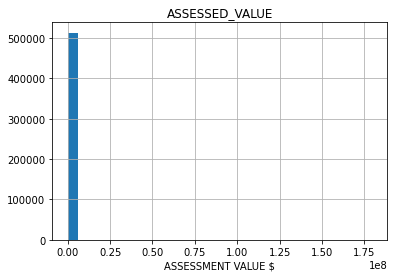

In [11]:
df['ASSESSED_VALUE'] = df['ASSESSED_VALUE'].astype(int)
df.hist(column='ASSESSED_VALUE', bins =30)
plt.xlabel("ASSESSMENT VALUE $")

What?? Why?? It looks as if we only have one column of values but the axis extends all the way to $175 Million. Clearly we have some outliers but they're spread out so far they're not showing up.

 I tried the standard rule for outlier removal (1.5 * the interquantile range), but wasn't very happy with the results. To handle this, I've instead written a convienence function to remove outliers based on the quantiles which allows for some trial and error and a qualitative judgement. In the end, we dropped a spike that may be from trailer homes which appear at the start, as well as the very high value homes above $1M or so. 

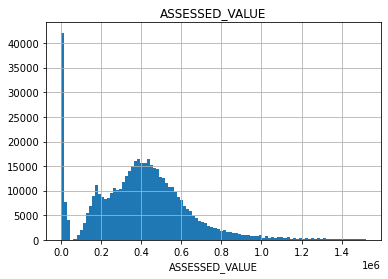

In [12]:
df_cut = quantile_cutter(df,'ASSESSED_VALUE',0.99,0,verbose=True)

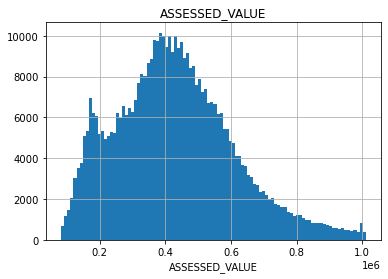

In [13]:
# Q1 = df.ASSESSED_VALUE.quantile(0.25)
# Q3 = df.ASSESSED_VALUE.quantile(0.75)
# IQR = Q3 - Q1
# outlier_mask = (df.ASSESSED_VALUE < (Q1 - 1.5 * IQR)) | (df.ASSESSED_VALUE > (Q3 + 1.5 * IQR) )
# df_cut = df[outlier_mask]
# df_cut.ASSESSED_VALUE.hist(bins=50)

df_cut = quantile_cutter(df,'ASSESSED_VALUE',0.97,0.11,verbose=True)

In [14]:
# I tried removing outliers from above the 75th percentile for the LAND_SIZE_SM and it decreased the dataset
# by about 100 000 rows. It also decreased the r^2 and MAE values. This is an interesting result worth investigating
# in the future.

# df_cut.describe()
# df_cut.LAND_SIZE_SM = pd.to_numeric(df_cut.LAND_SIZE_SM)
# df_cut.boxplot(vert = False)
# print(df_cut.shape)
# df_cut = quantile_cutter(df_cut,'LAND_SIZE_SM',0.75,0.01,verbose=True)
# print(df_cut.shape)

Other LAND_SIZE columns with suffixes SF and AC are the same land measurements but with equivalent values in square feet and acres and therefore will not be included in the columns chosen for the analysis of our model. 

In [15]:
to_keep = ['ASSESSED_VALUE','COMM_NAME', 'YEAR_OF_CONSTRUCTION', 'LAND_SIZE_SM']
df_chosen = df_cut[to_keep].copy()

 As seen below we see there are still a few object types left so we will convert them so that all features are numerical in preparation of giving it to our model. 

In [16]:
df_chosen.dtypes

ASSESSED_VALUE           int32
COMM_NAME               object
YEAR_OF_CONSTRUCTION    object
LAND_SIZE_SM            object
dtype: object

In [17]:
df_chosen['LAND_SIZE_SM'] = df_chosen['LAND_SIZE_SM'].astype(float)
df_chosen['YEAR_OF_CONSTRUCTION'] = df_chosen['YEAR_OF_CONSTRUCTION'].astype(int)

The COMM_NAME is categorical data and will be one-hot encoded instead.

In [18]:
#Use one-hot encoding for COMM_NAME
dummy = pd.get_dummies(df_chosen['COMM_NAME'])
df_chosen = pd.concat((df_chosen,dummy), axis=1)
df_chosen = df_chosen.drop(columns=['COMM_NAME'])

We are now ready to split our data and begin training it.

In [19]:
#Split data for training and testing
X = df_chosen.drop('ASSESSED_VALUE', axis=1)
y = df_chosen['ASSESSED_VALUE']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(297168, 245) (146367, 245) (297168,) (146367,)


Let's test it with a random forest regression model. This works by training a collection of decision trees on random subsamples of the dataset, and averages the output of all trees. This is a good choice because we are giving the model a range of different input types such as integers, floats, and one-hot encoded data, and I've read that the random forest model is a very robust algorithm that can usually handle that variety and give good results. It also should be good at capturing any non-linear relationships.

In [21]:
#Test with random forest
rf_regressor = RandomForestRegressor(n_estimators = 16, random_state = 1)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=16, random_state=1)

In [22]:
#Random forest accuracy
y_pred = rf_regressor.predict(X_test)
r_square = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print('r^2 =', r_square)
print('MAE =', MAE)

r^2 = 0.8387434732589701
MAE = 45309.4626011826


Generally a good $r^2$ should be above 0.7 from what I've read. But it can be very context dependent. It gives us a rough a idea of how well the model is performing. The MAE is the mean absolute error which gives us a dollar value range of how close our predicted values are on average from the actual.

Text(0.5, 1.0, 'Predicted')

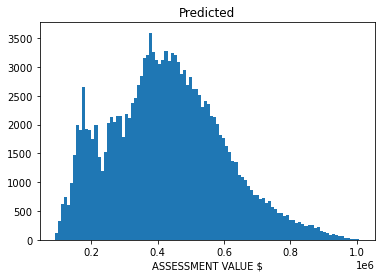

In [23]:
#Predicted
plt.hist(y_pred, bins=100)
plt.xlabel('ASSESSMENT VALUE $')
plt.title('Predicted')

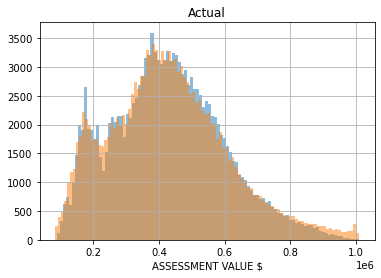

In [25]:
plt.hist(y_pred,bins=100, alpha=0.5)
y_test.hist(bins=100, alpha=0.5)
plt.xlabel('ASSESSMENT VALUE $')
plt.title("Actual")
plt.show()

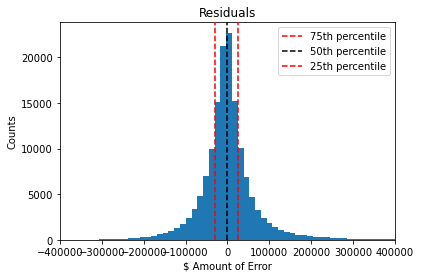

In [55]:
residuals = (y_test - y_pred)
_=plt.hist(residuals, bins=100)
plt.xlim(-400_000,400_000)
plt.title('Residuals')
plt.ylabel('Counts')
plt.xlabel('$ Amount of Error')

plt.axvline(np.quantile(residuals,0.75),zorder=3, color='red', linestyle='--',label='75th percentile')
plt.axvline(np.quantile(residuals,0.5),zorder=3, color='black', linestyle='--',label='50th percentile')
plt.axvline(np.quantile(residuals,0.25),zorder=3, color='red', linestyle='--',label='25th percentile')
plt.legend()


We can see from the above plots that the predicted values follow the general distribution of what was expected. The residuals are centered at 0 which is great because this means most of our errors are smaller errors.

## Conclusion and Future Works

We found that by using a random forest regressor, the model was able to predict with good performance of 0.84 for it's $r^2$ value. The model was also able to predict within about $45000 of the actual value. These results are not a good indication of how unconventional properties such as trailer homes would be assessed. However further analysis looking into outlier detection should be assessed to better avoid any unwanted biases from the land size and assessment values. Rigorous hyperparameter tuning should also be considered to optimize the model performance.